In [1]:
from dotenv import load_dotenv,dotenv_values
import json
import os

In [2]:
import requests
import http.client, urllib.parse
from tenacity import retry, stop_after_attempt, wait_fixed
from dotenv import load_dotenv  
from azure.core.credentials import AzureKeyCredential
from azure.identity import DefaultAzureCredential
from azure.search.documents import SearchClient  
from azure.search.documents.indexes import SearchIndexClient  
from azure.search.documents.models import (
    RawVectorQuery,
)
from azure.search.documents.indexes.models import (  
 
    ExhaustiveKnnParameters,  
    ExhaustiveKnnVectorSearchAlgorithmConfiguration,
    HnswParameters,  
    HnswVectorSearchAlgorithmConfiguration,
    SimpleField,
    SearchField,  
    SearchFieldDataType,  
    SearchIndex,  
    VectorSearch,  
    VectorSearchAlgorithmKind,  
    VectorSearchProfile,  
)

from IPython.display import Image, display

In [3]:
load_dotenv()  
service_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")  
index_name = os.getenv("AZURE_SEARCH_INDEX_NAME")
api_version = os.getenv("AZURE_SEARCH_API_VERSION")
key = os.getenv("AZURE_SEARCH_ADMIN_KEY")  
aiVisionApiKey = os.getenv("AZURE_AI_VISION_API_KEY")  
aiVisionRegion = os.getenv("AZURE_AI_VISION_REGION")
aiVisionEndpoint = os.getenv("AZURE_AI_VISION_ENDPOINT")
credential = AzureKeyCredential(key)

In [4]:
search_client = SearchClient(endpoint=service_endpoint, 
                             index_name=index_name, 
                             credential=credential)

In [5]:
query_image_path = "images/PIC01.jpeg"

In [6]:
@retry(stop=stop_after_attempt(5), wait=wait_fixed(1))
def get_image_vector(image_path, key, region):
    headers = {
        'Ocp-Apim-Subscription-Key': key,
    }

    params = urllib.parse.urlencode({
        'model-version': '2023-04-15',
    })

    try:
        if image_path.startswith(('http://', 'https://')):
            headers['Content-Type'] = 'application/json'              
            body = json.dumps({"url": image_path})
        else:
            headers['Content-Type'] = 'application/octet-stream'
            with open(image_path, "rb") as filehandler:
                image_data = filehandler.read()
                body = image_data

        conn = http.client.HTTPSConnection(f'{region}.api.cognitive.microsoft.com', timeout=3)
        conn.request("POST", "/computervision/retrieval:vectorizeImage?api-version=2023-04-01-preview&%s" % params, body, headers)
        response = conn.getresponse()
        data = json.load(response)
        conn.close()

        if response.status != 200:
            raise Exception(f"Error processing image {image_path}: {data.get('message', '')}")

        return data.get("vector")

    except (requests.exceptions.Timeout, http.client.HTTPException) as e:
        print(f"Timeout/Error for {image_path}. Retrying...")
        raise


In [7]:
vector_query = RawVectorQuery(vector=get_image_vector(query_image_path, 
                                                      aiVisionApiKey, 
                                                      aiVisionRegion),
                              k=3, 
                              fields="image_vector")  

In [8]:
# Perform vector search  
results = search_client.search(  
    search_text=None,  
    vector_queries= [vector_query],
    select=["description"]  
)   

Search results for images/PIC01.jpeg:


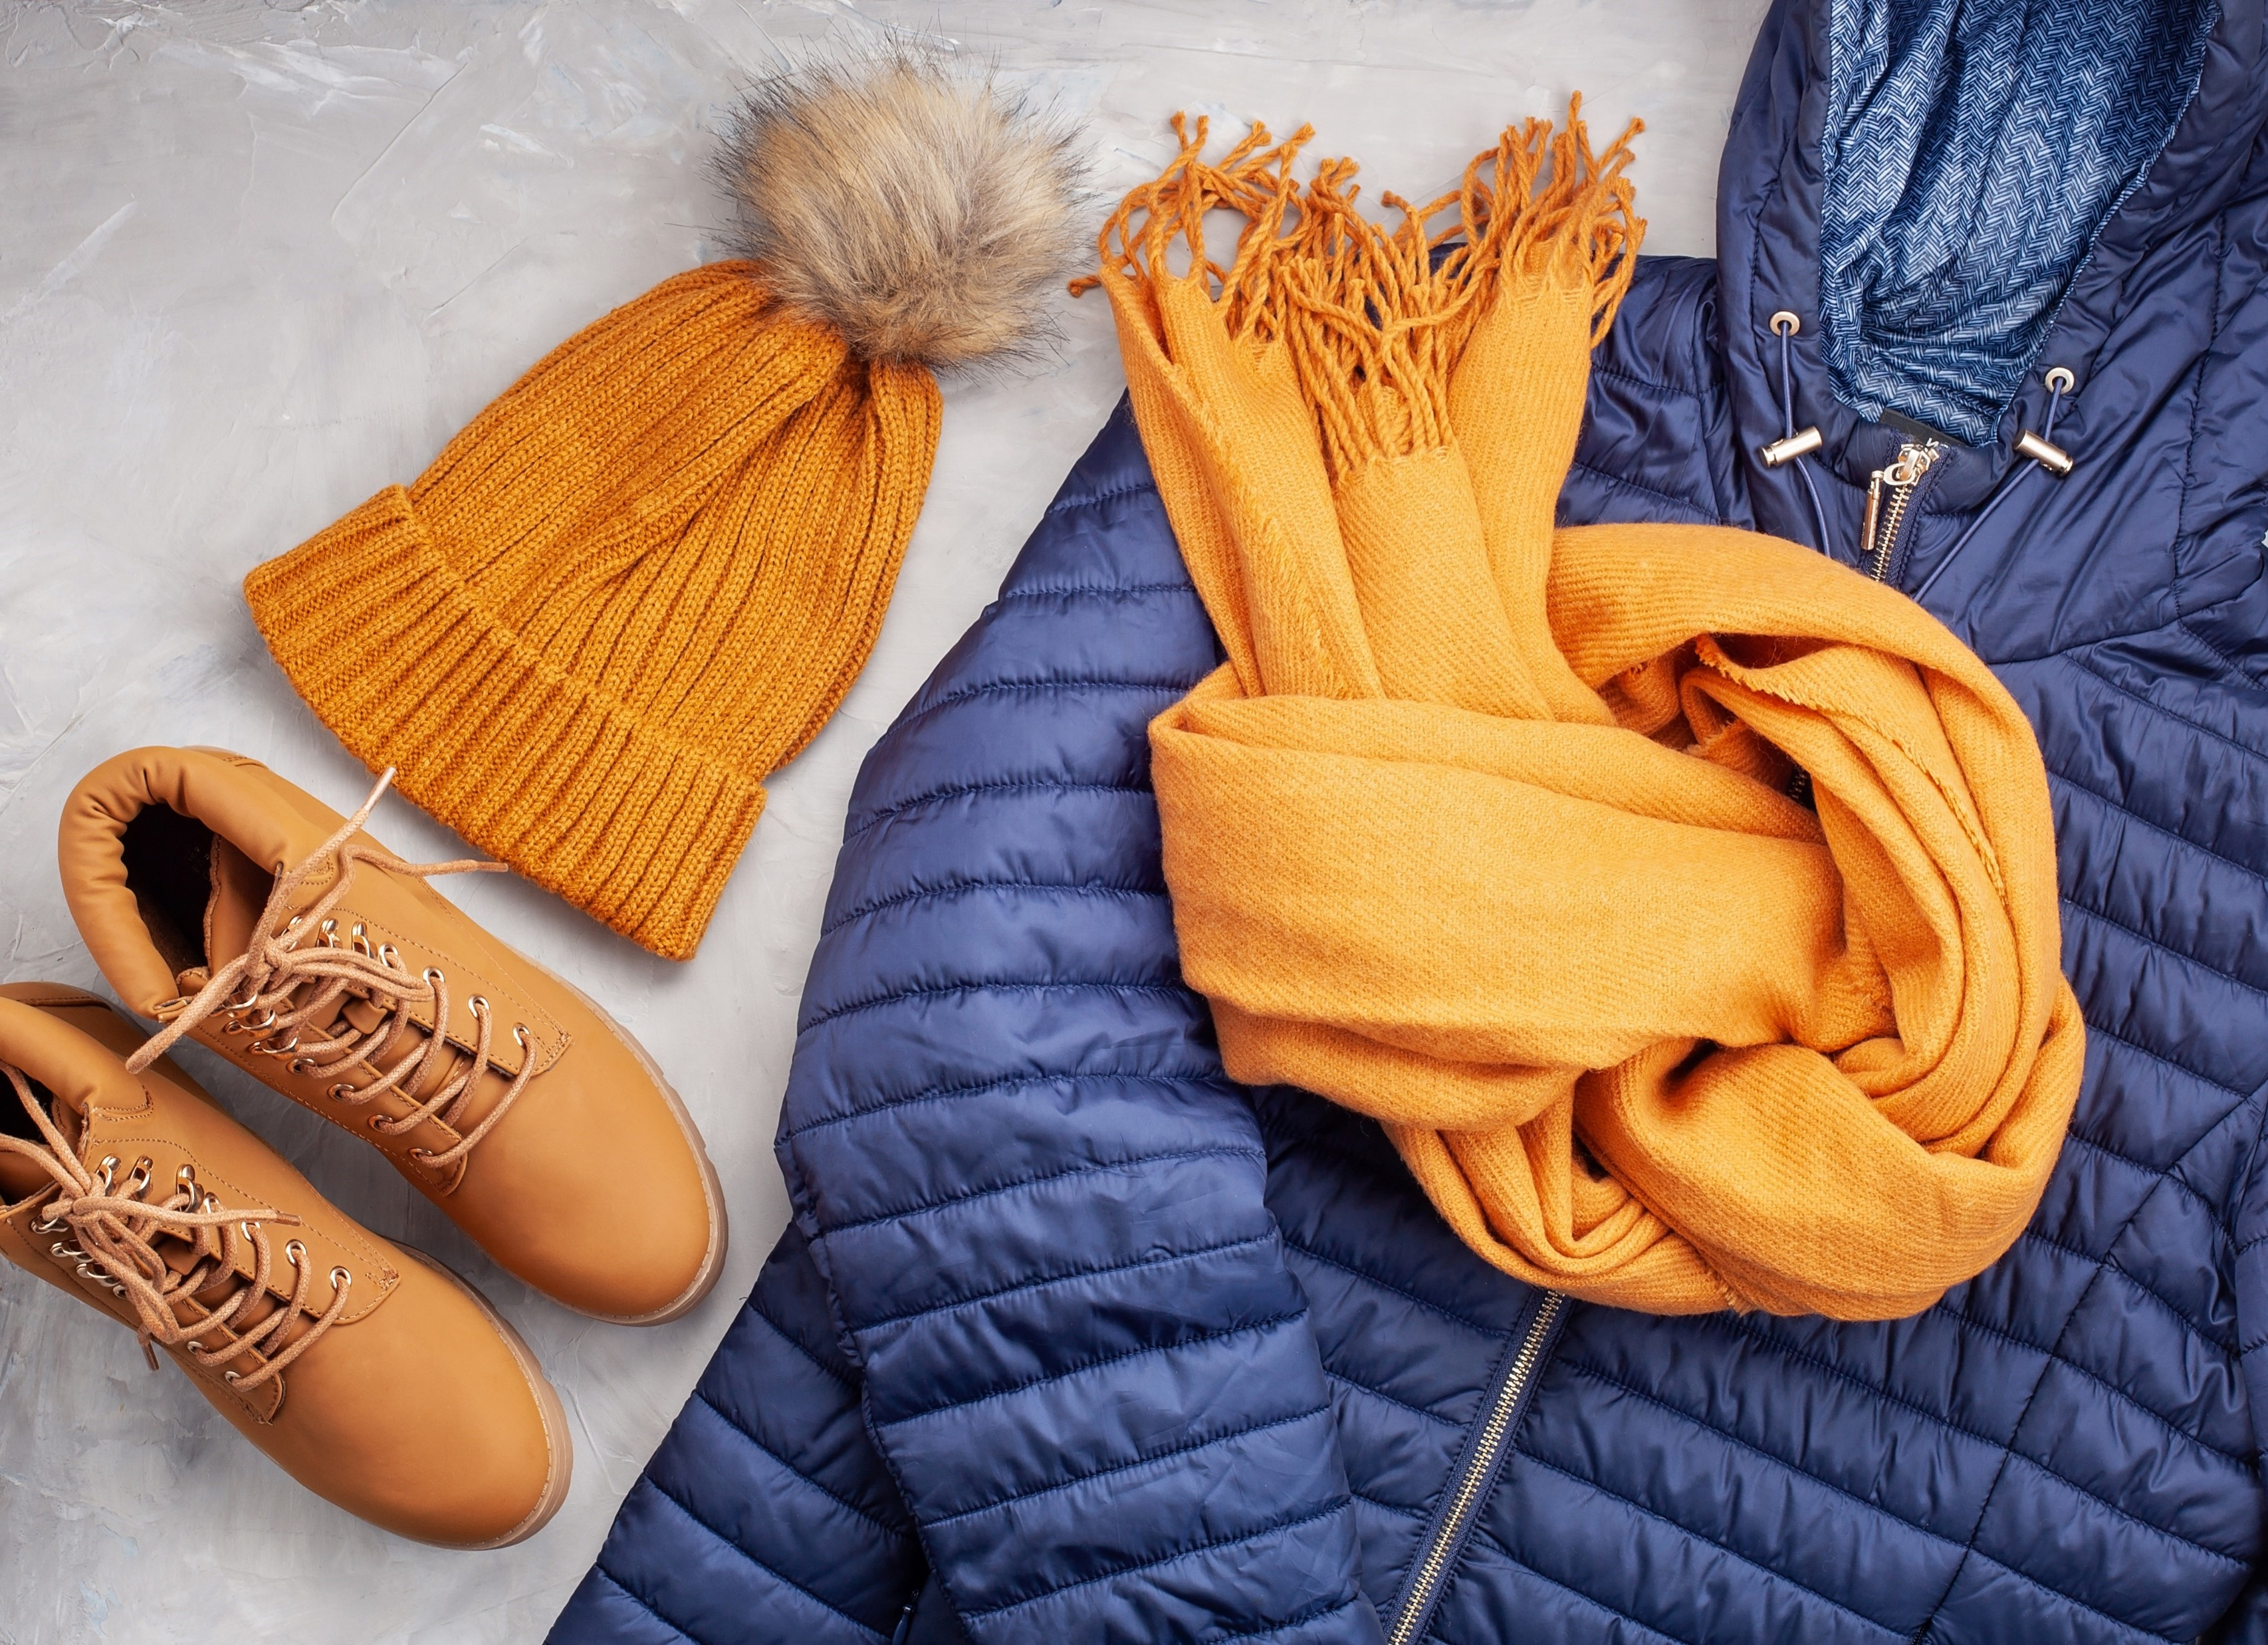

In [9]:
# Print the search results 
print(f"Search results for {query_image_path}:") 
display(Image(query_image_path))


In [10]:
DIR_PATH = os.getcwd()

In [11]:
DIR_PATH

'c:\\Ambarish\\AzureAI-ImageSearch'

PIC01.jpeg


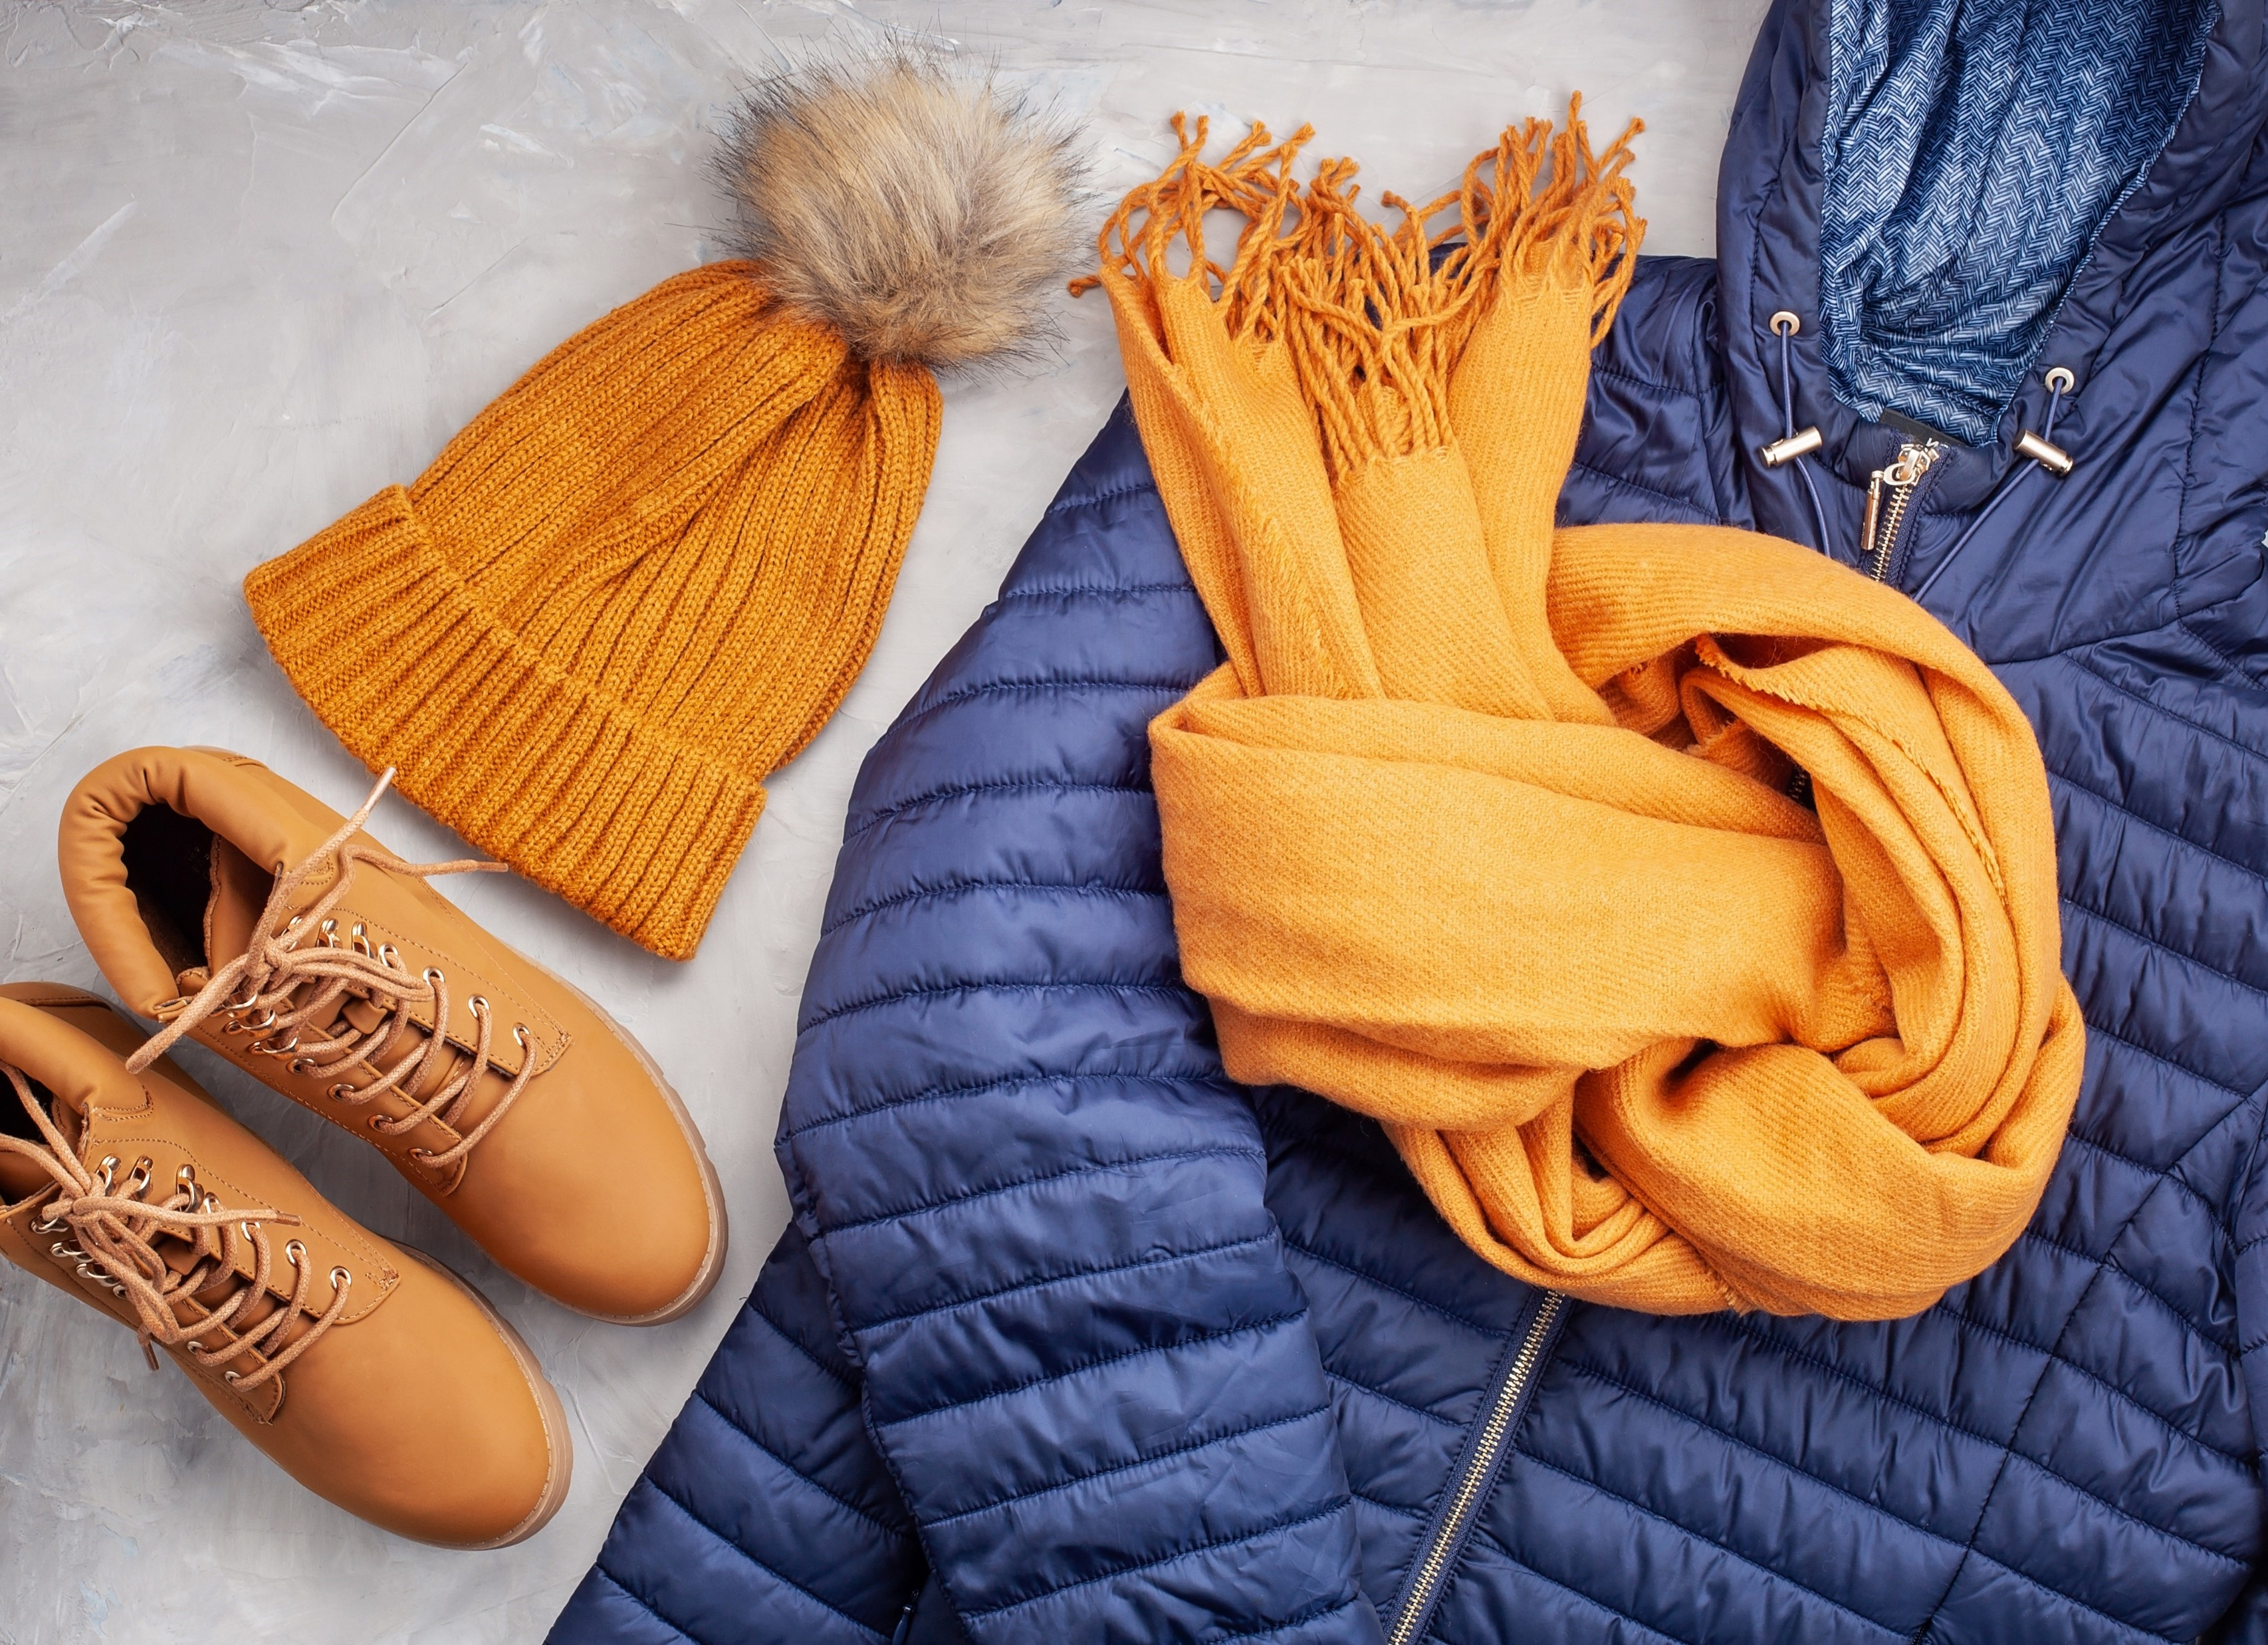



PIC02.jpeg


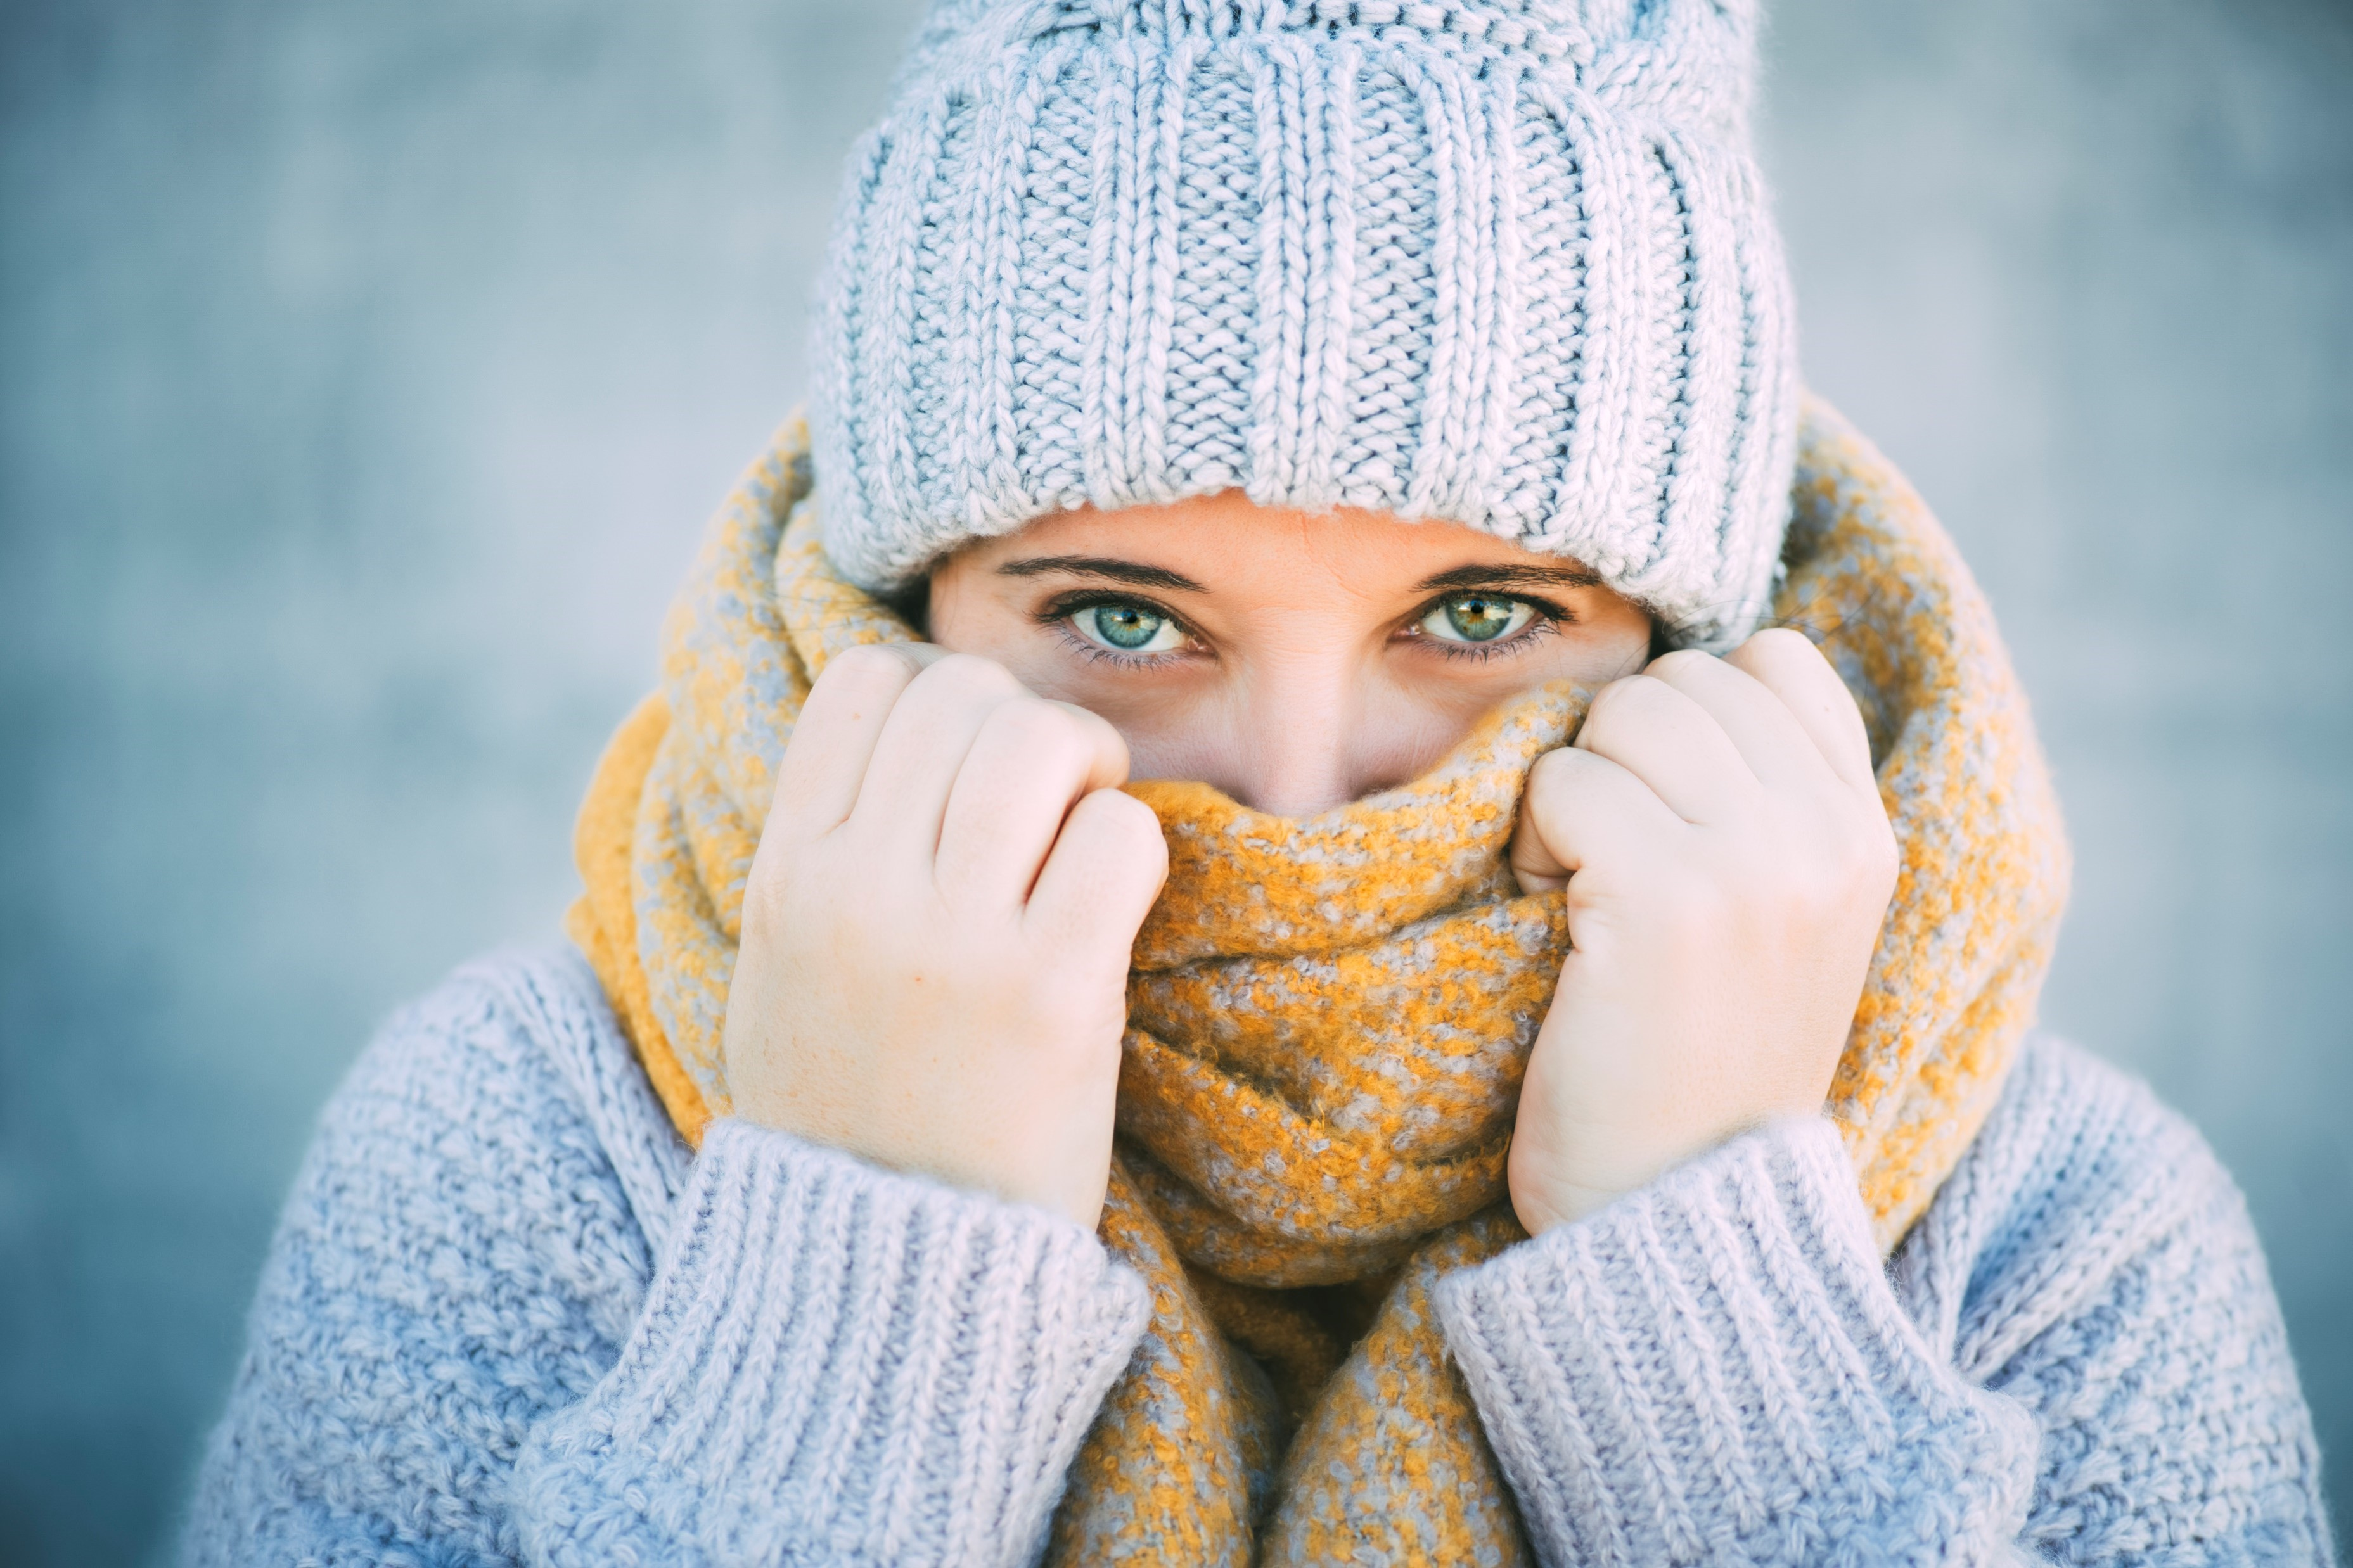



PIC03.jpeg


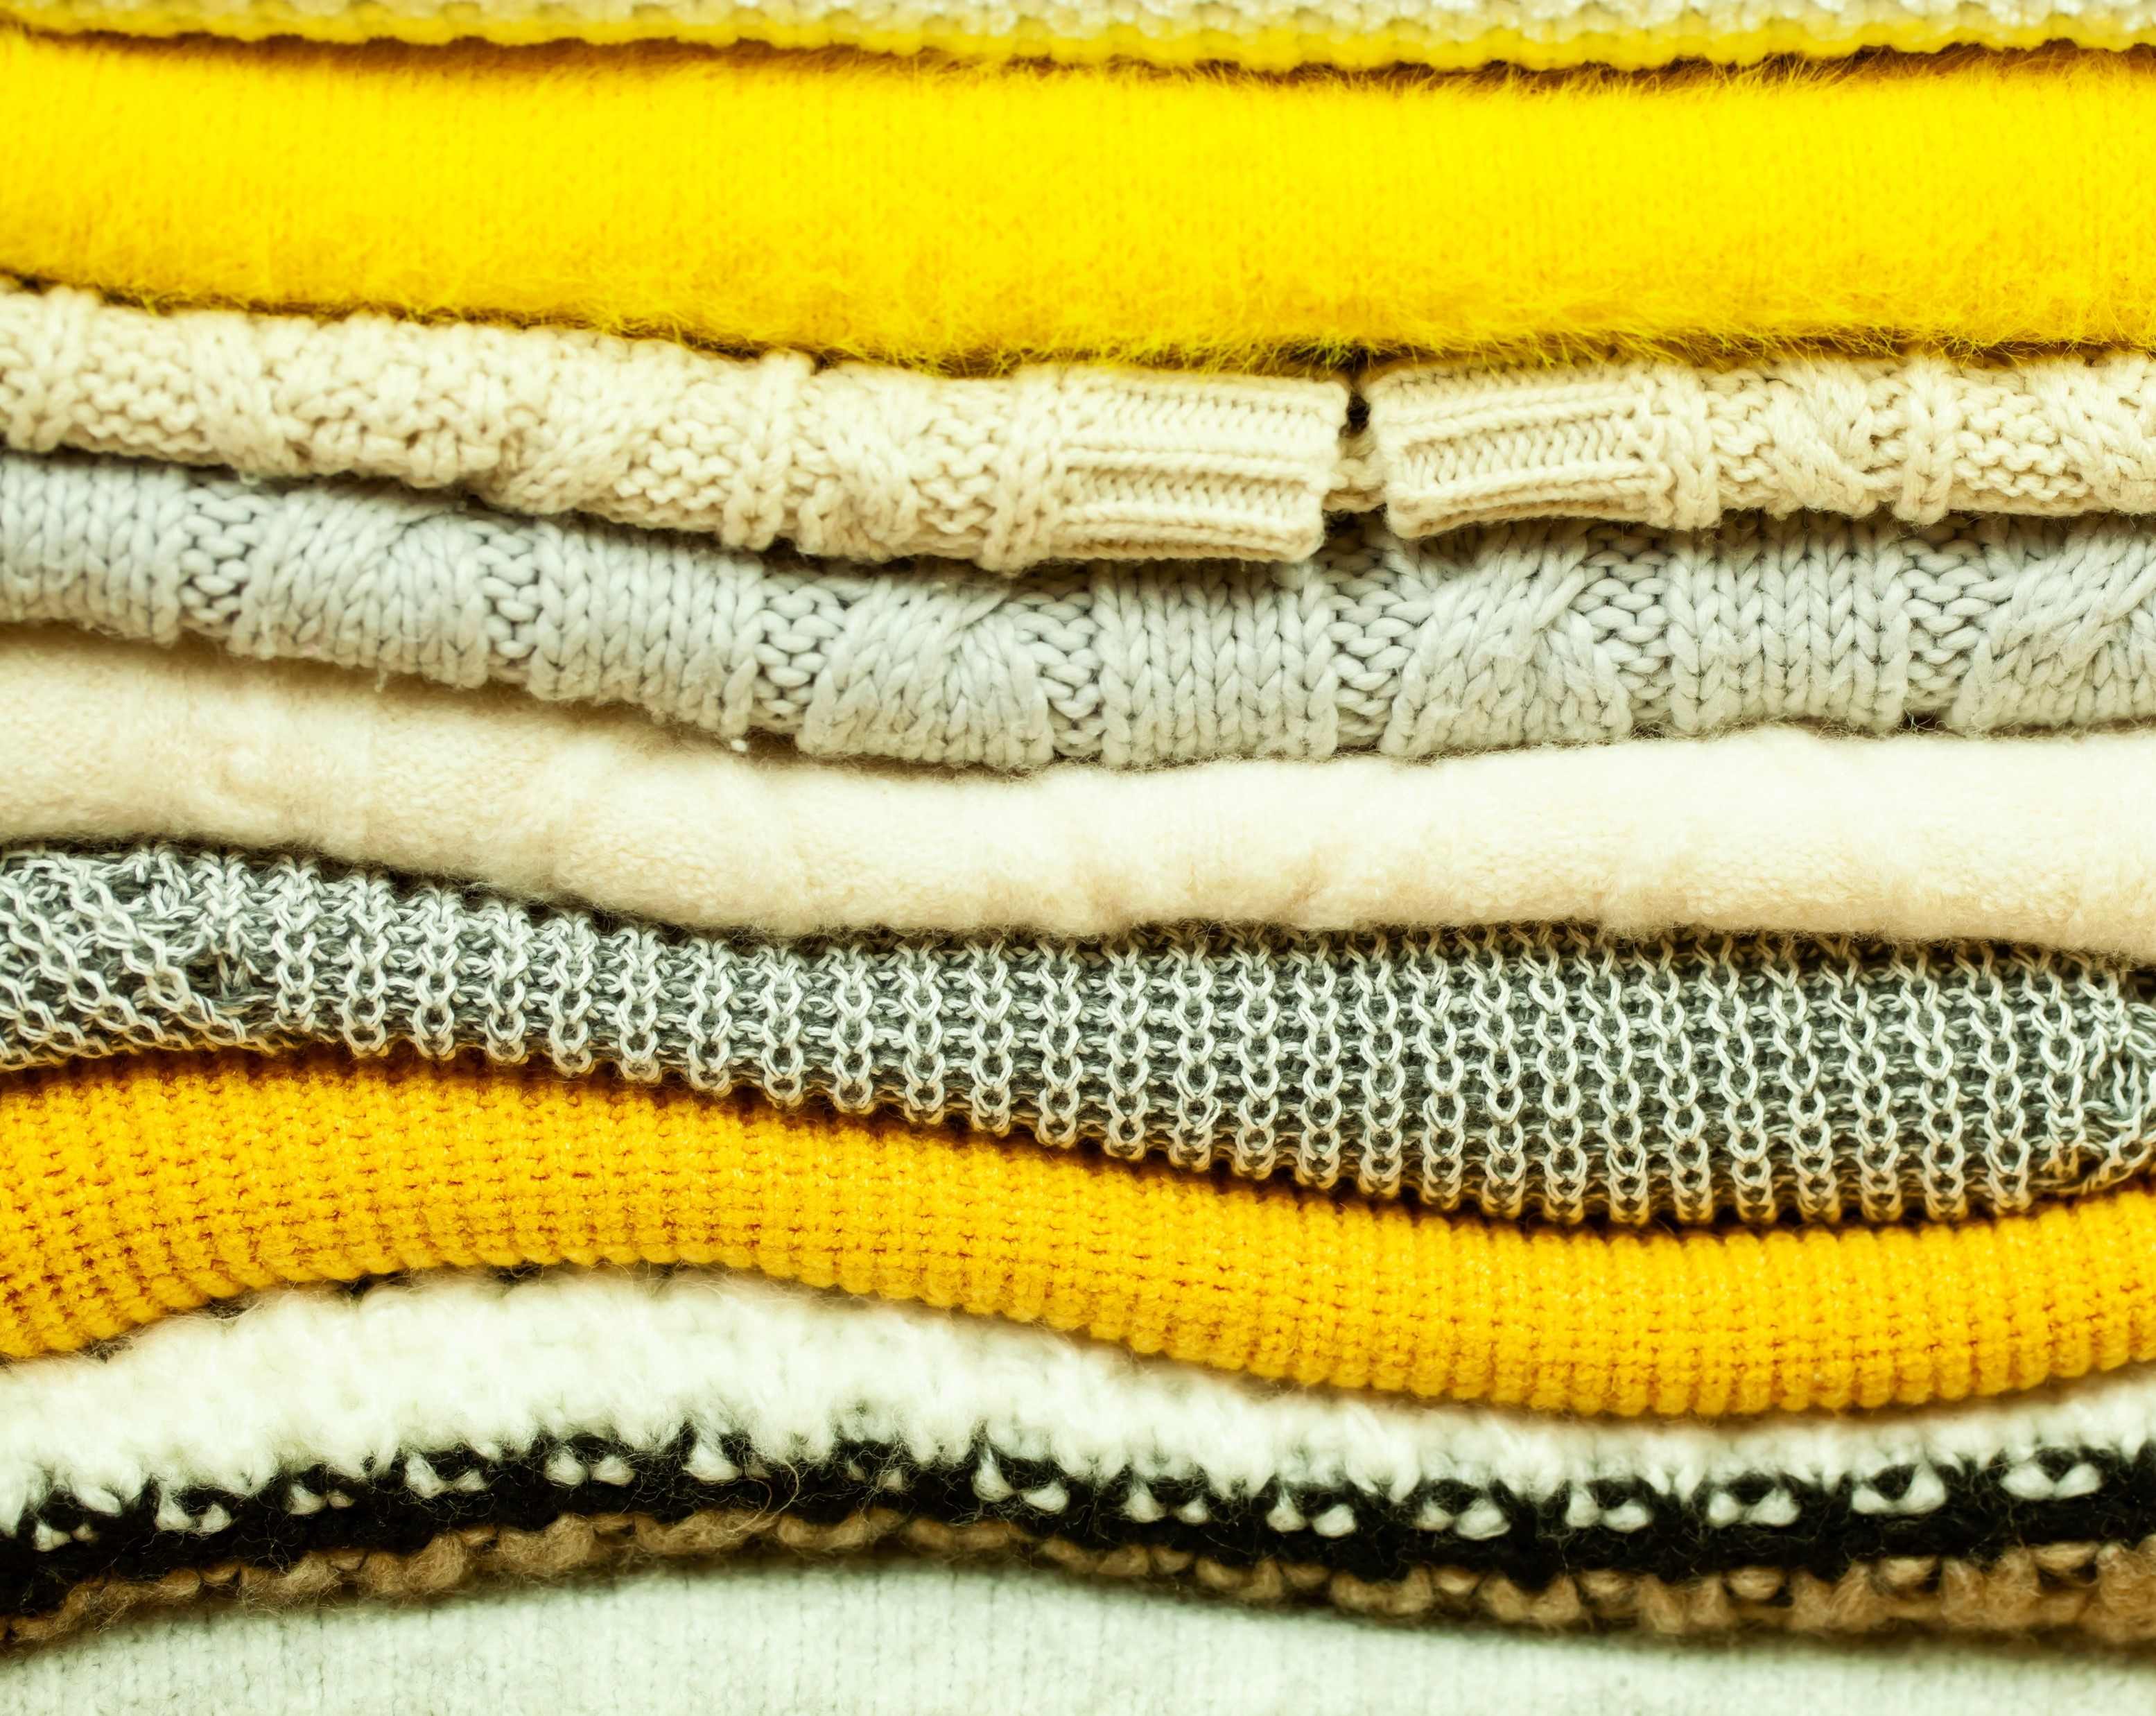

In [12]:
for result in results:
    print(f"{result['description']}")
    display(Image(DIR_PATH + "/images/" + result["description"]))
    print("\n") 

In [13]:
def generate_embeddings(text, aiVisionEndpoint, aiVisionApiKey):  
    url = f"{aiVisionEndpoint}/computervision/retrieval:vectorizeText"  
  
    params = {  
        "api-version": "2023-02-01-preview"  
    }  
  
    headers = {  
        "Content-Type": "application/json",  
        "Ocp-Apim-Subscription-Key": aiVisionApiKey  
    }  
  
    data = {  
        "text": text  
    }  
  
    response = requests.post(url, params=params, headers=headers, json=data)  
  
    if response.status_code == 200:  
        embeddings = response.json()["vector"]  
        return embeddings  
    else:  
        print(f"Error: {response.status_code} - {response.text}")  
        return None  

In [25]:
query = "woman"

In [26]:
vector_text = generate_embeddings(query, aiVisionEndpoint, aiVisionApiKey)

In [27]:
vector_query = RawVectorQuery(vector=vector_text,
                              k=3, 
                              fields="image_vector")  

In [28]:
# Perform vector search  
results = search_client.search(  
    search_text=None,  
    vector_queries= [vector_query],
    select=["description"]  
)  

PIC04.jpeg


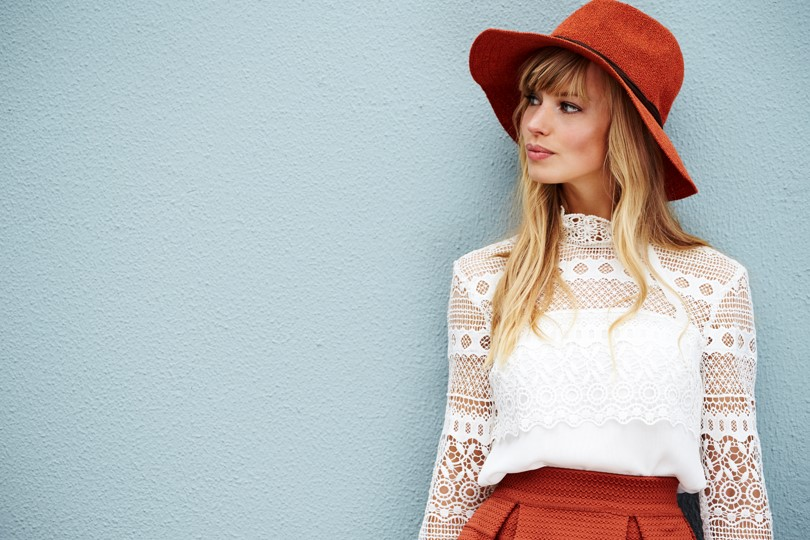



PIC05.jpeg


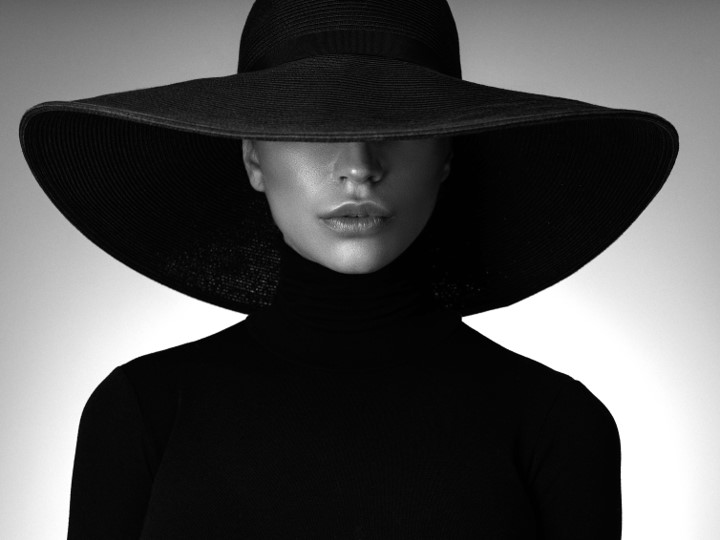



PIC06.jpeg


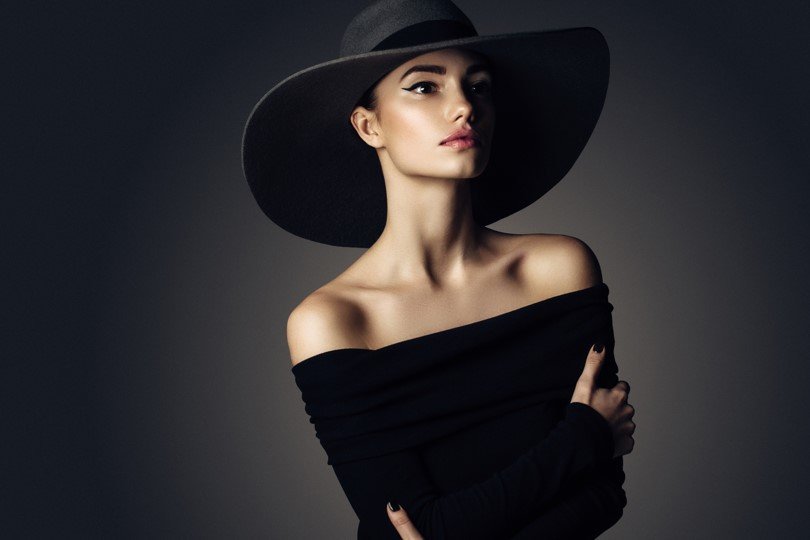

In [29]:
for result in results:
    print(f"{result['description']}")
    display(Image(DIR_PATH + "/images/" + result["description"]))
    print("\n") 